<ipython-input-5-839ccd3b0b5b>:20: RuntimeWarning: overflow encountered in long_scalars
  state[0] = (state[0] * 16807) % 2147483647
<ipython-input-5-839ccd3b0b5b>:20: RuntimeWarning: overflow encountered in int_scalars
  state[0] = (state[0] * 16807) % 2147483647
<ipython-input-5-839ccd3b0b5b>:16: RuntimeWarning: overflow encountered in int_scalars
  return max(1, (state1 + state2) % 2147483647)
<ipython-input-5-839ccd3b0b5b>:12: RuntimeWarning: overflow encountered in int_scalars
  return (x * prime0) ^ (y * prime1) ^ (d * prime2)
<ipython-input-5-839ccd3b0b5b>:130: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


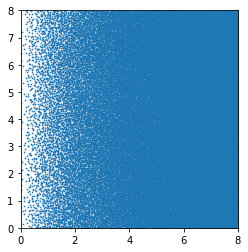

In [5]:
import numpy as np
import matplotlib.pyplot as plt


class Random(object):

    @staticmethod
    def state_from_int3(x, y, d):
        prime0 = 73856093
        prime1 = 471943
        prime2 = 83492791
        return (x * prime0) ^ (y * prime1) ^ (d * prime2)

    @staticmethod
    def combine(state1, state2):
        return max(1, (state1 + state2) % 2147483647)

    @staticmethod
    def generate(state):
        state[0] = (state[0] * 16807) % 2147483647
        return state[0]

    @staticmethod
    def get_canonical(state):
        base = 2147483648.0  # 2147483646.0 gets rounded to 2147483648.0f in float32
        sp = Random.generate(state) - 1.0
        return sp / base

    @staticmethod
    def get_uniform_int(state, n):
        """
        Generates a random integer uniformly in [0, n].
        Assumes n <= 2147483647 (downscaling).
        """
        uerange = n + 1
        urngrange = 2147483647
        scaling = urngrange // uerange
        past = uerange * scaling
        ret = Random.generate(state) - 1
        while (ret >= past):
            ret = Random.generate(state) - 1
        return ret // scaling

    @staticmethod
    def permutation(state, n):
        # Knuth shuffle to generate random permutation
        t = [i for i in range(n)]
        for i in range(n):
            j = Random.get_uniform_int(state, i)
            t[i] = t[j]
            t[j] = i
        return t

    @staticmethod
    def sample_new_point(state, origin_square, length_halfsquare, subidx):
        dx, dy = subidx % 2, subidx // 2
        offset = length_halfsquare * np.array([dx, dy], dtype=float)
        random_offset = np.array([Random.get_canonical(state), Random.get_canonical(state)])
        return origin_square + random_offset * length_halfsquare + offset


def subdivide_square(origin_square_coarse, coarse_level_length, seeds,
                     density_func, grid_offset, rng_offset):
    ij = np.array([0, 0], dtype=int)
    d = 0
    while True:
        length_square = coarse_level_length / float(2**d)
        origin_square = origin_square_coarse + length_square * ij
        length_halfsquare = 0.5 * length_square
        rho = density_func(origin_square + length_halfsquare)
        target_seeds = (length_square ** 2) * rho
        if target_seeds <= 4:
            # 1st case: the cell is a leaf
            idx_offset = grid_offset * 2**d
            rng_seed = Random.state_from_int3(ij[0] + idx_offset[0], ij[1] + idx_offset[1], d)
            rng_state = [Random.combine(rng_seed, rng_offset)]
            shuffled_idx = Random.permutation(rng_state, 4)
            min_samples = int(np.floor(target_seeds))
            proba_last = target_seeds - min_samples
            for i in range(min_samples):
                seeds.append(Random.sample_new_point(
                    rng_state, origin_square, length_halfsquare, shuffled_idx[i]))
            if Random.get_canonical(rng_state) <= proba_last and min_samples < 4:
                seeds.append(Random.sample_new_point(
                    rng_state, origin_square, length_halfsquare, shuffled_idx[min_samples]))
            # move up to nodes if required
            while np.all(ij % 2) and d > 0:
                d = d - 1
                ij = ij // 2
            if d > 0:
                # move to next seed
                if ij[0] % 2 == 0:
                    ij[0] += 1
                else:
                    ij[0] -= 1
                    ij[1] += 1
            else:
                break
        else:
            # 2nd case: the cell is a node
            d = d + 1
            ij = ij * 2
    return


def generate_seeds(coarse_level_length, extent):
    def density_func(point):
        # grading in x direction
        seed_density_factor = 2000
        return (point[0] / extent[0]) * seed_density_factor  # seeds / mm^2

    seeds = []
    rng_offset = np.random.randint(0, 2147483647)  # allow for different random realizations
    for origin_x in np.arange(0.0, extent[0], coarse_level_length):
        for origin_y in np.arange(0.0, extent[1], coarse_level_length):
            origin_square_coarse = np.array([origin_x, origin_y], dtype=float)
            grid_offset = np.floor_divide(origin_square_coarse, coarse_level_length).astype(int)
            subdivide_square(origin_square_coarse, coarse_level_length, seeds,
                             density_func, grid_offset, rng_offset)

    return seeds

def grid_cell_enclosing(q):
    """Finds the grid cell enclosing the query point q

    Args:
        q (vector2): The query point (xy)
    """

def gather_seeds(density_field, q):
    """Gets all seeds around a point q from the density field

    Args:
        density_field (matrix)
        q (vector2)
    """


def eval_structure(density_field, beam_radius, q):
    pass


def plot_seeds(seeds, extent):
    seeds_x = [s[0] for s in seeds]
    seeds_y = [s[1] for s in seeds]
    plt.scatter(seeds_x, seeds_y, s=0.5)
    plt.xlim([0, extent[0]])
    plt.ylim([0, extent[1]])
    plt.axes().set_aspect('equal')
    plt.show()


if __name__ == "__main__":
    coarse_level_length = 8.0  # (mm)
    extent = np.array([8.0, 8.0], dtype=float)  # (mm)
    seeds = generate_seeds(coarse_level_length, extent)
    plot_seeds(seeds, extent)
